In [40]:
from catboost import CatBoostClassifier, Pool
import pandas as pd
from sklearn.model_selection import train_test_split

In [258]:
def merge_ndvi(df: pd.DataFrame, next_col_iter: callable, postfix=0) -> pd.DataFrame:
    nd_cols = get_ndvi_columns(df)
    tmp = df.copy()

    curr_idx = 0
    curr_col = nd_cols[0]
    next_col = next_col_iter(nd_cols, curr_col)
    while next_col is not None:
        tmp[f"mean_{curr_idx}_{postfix}"] = df.loc[:, curr_col:next_col].mean(axis=1)
        tmp[f"median_{curr_idx}_{postfix}"] = df.loc[:, curr_col:next_col].median(axis=1)
        tmp[f"max_{curr_idx}_{postfix}"] = df.loc[:, curr_col:next_col].max(axis=1)
        tmp[f"min_{curr_idx}_{postfix}"] = df.loc[:, curr_col:next_col].min(axis=1)
        tmp[f"std_{curr_idx}_{postfix}"] = df.loc[:, curr_col:next_col].std(axis=1)
        tmp[f"range_{curr_idx}_{postfix}"] = tmp[f"max_{curr_idx}_{postfix}"] - tmp[f"min_{curr_idx}_{postfix}"]
        curr_col = next_col
        next_col = next_col_iter(nd_cols, curr_col)
        curr_idx += 1
    return tmp

def half_month(cols: list[str], curr: str):
    next_col = None

    def dm(col):
        return tuple(map(int, col.split("-")[-2:]))[::-1]

    day_curr, month_curr = dm(curr)

    if day_curr >= 15:
        for c in cols:
            if dm(c)[1] > month_curr:
                next_col = c
                break
    else:
        for c in cols:
            d, m = dm(c)
            if d >= 15 and m == month_curr:
                next_col = c
                break

    if next_col is None and cols.index(curr) != len(cols) - 1:
        return cols[-1]

    return next_col


In [259]:
import datetime as dt

def n_days(cols: list[str], curr: str, dist: int = 10) -> str:
    next_col = None

    def get_date(label: str) -> dt.datetime:
        return dt.datetime(*map(int, label.replace('-', '_').split('_')[-3:]))


    curr_date = get_date(curr)

    for c in cols:
        col_date = get_date(c)
        if (col_date - curr_date).days >= dist:
            next_col = c
            break

    if next_col is None and cols.index(curr) != len(cols) - 1:
        return cols[-1]

    return next_col


def interval(dist_in_days: int) -> callable:
    def func(cols, curr):
        return n_days(cols, curr, dist_in_days)
    return func

In [2]:
from src.util import drop_unused_cols, get_ndvi_transformer, get_ndvi_columns, df_to_gdf, add_region, encode_region, sort_cols

In [4]:
DATA_DIR = "data/"

In [5]:
train_df = sort_cols(pd.read_csv(DATA_DIR + "train_dataset_train.csv").set_index("id"))
test_df = sort_cols(pd.read_csv(DATA_DIR + "test_dataset_test.csv").set_index("id"))

In [6]:
import geopandas as gpd

In [7]:
regions = gpd.read_file(DATA_DIR + "boundaries/admin_level_4.shp", encoding='cp1251')[["geometry", "name_en"]]
train_df = df_to_gdf(train_df)
test_df = df_to_gdf(test_df)

add_region(train_df, regions)
encode_region(train_df)

add_region(test_df, regions)
encode_region(test_df)

In [8]:
with_regions = (train_df.copy(), test_df.copy())

In [6]:
# train_df = merge_mean(train_df, half_month)
# test_df = merge_mean(test_df, half_month)

In [9]:
def add_centroid_coordinates(df: gpd.GeoDataFrame):
    df["center_x"] = df.geometry.centroid.x
    df["center_y"] = df.geometry.centroid.y

In [10]:
def add_diff(p):
    return p.join(p.loc[:, get_ndvi_columns(p)].diff(axis=1).rename(columns={col: col + "_diff" for col in p.columns}).iloc[:, 1:])

In [302]:
train_df, test_df = with_regions
with_regions = (train_df.copy(), test_df.copy())

In [303]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(get_ndvi_columns(train_df))

def add_min_max_positions(p: pd.DataFrame):
    p["min_at"] = le.transform(p.loc[:, get_ndvi_columns(p)].apply('idxmin', axis=1))
    p["max_at"] = le.transform(p.loc[:, get_ndvi_columns(p)].apply('idxmax', axis=1))
    p["mean_all"] = p[get_ndvi_columns(p)].mean(axis=1)
    p["median_all"] = p[get_ndvi_columns(p)].median(axis=1)
    p["max_all"] = p[get_ndvi_columns(p)].max(axis=1)
    p["min_all"] = p[get_ndvi_columns(p)].min(axis=1)
    p["range_all"] = p["max_all"] - p["min_all"]
    p["std_all"] = p[get_ndvi_columns(p)].std(axis=1)


In [304]:
train_df = merge_ndvi(train_df, half_month, 0)
test_df = merge_ndvi(test_df, half_month, 0)

# train_df = merge_ndvi(train_df, n_days, 1)
# test_df = merge_ndvi(test_df, n_days, 1)
#
# train_df = merge_ndvi(train_df, interval(5), 2)
# test_df = merge_ndvi(test_df, interval(5), 2)

add_centroid_coordinates(train_df)
add_centroid_coordinates(test_df)

add_min_max_positions(train_df)
add_min_max_positions(test_df)

train_df = add_diff(train_df).copy()
test_df = add_diff(test_df).copy()

In [305]:
train_df.head(5)

,area,crop,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,...,nd_mean_2021-07-29_diff,nd_mean_2021-07-31_diff,nd_mean_2021-08-01_diff,nd_mean_2021-08-07_diff,nd_mean_2021-08-10_diff,nd_mean_2021-08-11_diff,nd_mean_2021-08-12_diff,nd_mean_2021-08-13_diff,nd_mean_2021-08-23_diff,nd_mean_2021-08-27_diff
id,,,,,,,,,,,,,,,,,,,,,
3536,20,3,0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,0.000000,0.077577,...,0.614582,-0.727516,0.754859,-0.754859,0.030883,-0.030883,0.658016,-0.531184,-0.091974,0.579913
3739,45,4,0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,0.024539,0.173578,...,0.593114,-0.577196,0.616505,-0.521995,-0.121649,0.555893,-0.016790,-0.426771,-0.174914,0.179612
1294,28,2,0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,0.112471,0.041751,...,0.202447,0.089341,-0.411168,0.357296,-0.311926,0.126710,-0.172080,0.090607,-0.090607,0.054127
2859,19,5,0.293425,0.105976,0.318047,0.052500,0.153700,0.001917,0.045054,0.072589,...,-0.242224,0.055983,0.096210,-0.091537,0.292067,0.026473,-0.052172,-0.253533,-0.011716,0.317124
3685,33,4,0.027983,0.130885,0.117227,0.063492,0.040565,0.024416,0.163886,0.109385,...,0.072117,-0.222586,0.161855,-0.772962,0.080592,-0.080592,0.055220,0.102456,-0.135424,-0.010203


In [306]:
drop_columns = ["geometry", "area"]

In [307]:
X = train_df.drop(columns=drop_columns + ["crop"]).rename(columns={c: c.replace('-', '_') for c in train_df.columns})
y = train_df.crop.ravel()

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [313]:
train_pool = Pool(X_train, y_train)

/home/eugen/PycharmProjects/inno-ndvi/venv/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [314]:
val_pool = Pool(X_test, y_test)

/home/eugen/PycharmProjects/inno-ndvi/venv/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [315]:
X_train.head()

,nd_mean_2021_04_15,nd_mean_2021_04_16,nd_mean_2021_04_18,nd_mean_2021_04_19,nd_mean_2021_04_20,nd_mean_2021_04_22,nd_mean_2021_04_23,nd_mean_2021_04_25,nd_mean_2021_04_26,nd_mean_2021_04_27,...,nd_mean_2021_07_29_diff,nd_mean_2021_07_31_diff,nd_mean_2021_08_01_diff,nd_mean_2021_08_07_diff,nd_mean_2021_08_10_diff,nd_mean_2021_08_11_diff,nd_mean_2021_08_12_diff,nd_mean_2021_08_13_diff,nd_mean_2021_08_23_diff,nd_mean_2021_08_27_diff
id,,,,,,,,,,,,,,,,,,,,,
6409,0.000000,0.037135,0.015749,0.000000,0.182830,0.207616,0.027744,0.027290,0.092678,0.257482,...,0.378002,-0.384972,0.271441,-0.345706,0.052434,0.079557,0.368816,-0.451308,0.327547,-0.321390
6519,0.227408,0.128629,0.275322,0.187845,0.127528,0.038857,0.034924,0.117451,0.125908,0.088151,...,0.496774,-0.051099,-0.319751,0.446460,-0.539421,0.487873,-0.005371,-0.583756,0.041196,0.125809
4036,0.170192,0.121201,0.000000,0.000000,0.053998,0.157252,0.003495,0.074632,0.092461,0.000000,...,0.049052,-0.450791,0.702900,-0.712608,0.708055,-0.090499,0.031403,-0.594301,0.506832,-0.561490
3317,0.285390,0.275915,0.321153,0.039442,0.294017,0.000000,0.000000,0.000000,0.323175,0.000000,...,0.048322,0.027319,0.068758,-0.092168,0.009142,0.358153,0.030113,-0.243704,0.027877,0.133714
2449,0.048812,0.311239,0.112258,0.000000,0.050039,0.108197,0.120096,0.000000,0.263010,0.008869,...,-0.050157,0.000000,0.113352,-0.113352,0.113625,-0.113625,0.394566,-0.235011,-0.069833,-0.035744


In [320]:
model = CatBoostClassifier(
    learning_rate=0.03,
    random_seed=42,
    loss_function='MultiClass',
    thread_count=8,
    verbose=True,
    eval_metric='Accuracy',
    iterations=1_500,
    bagging_temperature=0.2,
    od_type='Iter',
    od_wait=250,
)

In [334]:
import warnings
warnings.filterwarnings("ignore")

In [342]:
from src.util import get_label_encoder
from sklearn.metrics import recall_score

all_preds = X_test.copy()
all_preds["crop"] = 0

for i, region in enumerate(get_label_encoder().classes_):
    print(region)
    reg_model = CatBoostClassifier(
        learning_rate=0.03,
        random_seed=42,
        loss_function='MultiClass',
        thread_count=8,
        verbose=False,
        eval_metric='Accuracy',
        iterations=1_500,
        bagging_temperature=0.2,
        od_type='Iter',
        od_wait=250,
        eval_fraction=0.3
    )
    flt = X.region == i
    reg_train_pool = Pool(X[flt].drop(columns=["region"]), y[flt])
    selected = reg_model.select_features(reg_train_pool,
                                 features_for_select=X_train.drop(columns=["region"]).columns.tolist(),
                                 num_features_to_select=len(X_train.columns) - 20, logging_level='Silent')
    pred = model.predict(Pool(X_test[X_test.region == i].drop(columns=["region"])))
    all_preds.loc[all_preds.region == i, "crop"] = pred
    print(reg_model.best_score_)

print('Test total:', recall_score(y_test, all_preds["crop"].ravel(), average="macro", zero_division=0))

Bashkortostan
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.020406840787539342}, 'validation': {'Accuracy': 0.9858490566037735, 'MultiClass': 0.0653124682406629}}
Bryansk Oblast
{'learn': {'Accuracy': 0.9980430528375733, 'MultiClass': 0.04901355497975275}, 'validation': {'Accuracy': 0.9819004524886877, 'MultiClass': 0.11386206209136977}}
Chelyabinsk Oblast


{'learn': {'Accuracy': 1.0, 'MultiClass': 0.34550706944471143}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.47113903760599246}}
Kaluga Oblast


{'learn': {'Accuracy': 1.0, 'MultiClass': 0.28104762334079925}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.5076259801617218}}
Lipetsk Oblast


{'learn': {'Accuracy': 1.0, 'MultiClass': 0.12474431312150139}, 'validation': {'Accuracy': 0.7872340425531915, 'MultiClass': 0.6576025541041332}}
Moscow Oblast


{'learn': {'Accuracy': 1.0, 'MultiClass': 0.23545217932417215}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.49777394993408336}}
Nizhny Novgorod Oblast
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.03249304989527946}, 'validation': {'Accuracy': 0.99, 'MultiClass': 0.11557353079209004}}
Oryol Oblast


{'learn': {'Accuracy': 1.0, 'MultiClass': 0.05603406315853136}, 'validation': {'Accuracy': 0.9375, 'MultiClass': 0.30836723315157366}}
Perm Krai
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.1981461752896624}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.3515940888104621}}
Ryazan Oblast
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.048194378573837786}, 'validation': {'Accuracy': 0.8846153846153846, 'MultiClass': 0.36589678559873584}}
Sverdlovsk Oblast
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.08529835723861773}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.11918288617456349}}
Tatarstan
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.024959757774622972}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.03932004755546074}}
Tula Oblast
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.032810970951023845}, 'validation': {'Accuracy': 0.98989898989899, 'MultiClass': 0.1058500117264481}}
Voronezh Oblast
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.04889979371940632}, 'validation': {'Accuracy': 0.9421

In [321]:
selected = model.select_features(train_pool, eval_set=val_pool,
                                 features_for_select=X_train.columns.tolist(),
                                 num_features_to_select=130)

Step #1 out of 1
0:	learn: 0.6409346	test: 0.6335404	best: 0.6335404 (0)	total: 184ms	remaining: 4m 36s
1:	learn: 0.6619343	test: 0.6466529	best: 0.6466529 (1)	total: 256ms	remaining: 3m 11s
2:	learn: 0.7264123	test: 0.7170462	best: 0.7170462 (2)	total: 335ms	remaining: 2m 47s
3:	learn: 0.7577640	test: 0.7370600	best: 0.7370600 (3)	total: 403ms	remaining: 2m 30s
4:	learn: 0.7953268	test: 0.7908903	best: 0.7908903 (4)	total: 475ms	remaining: 2m 22s
5:	learn: 0.7965099	test: 0.7839890	best: 0.7908903 (4)	total: 550ms	remaining: 2m 17s
6:	learn: 0.8041999	test: 0.7902001	best: 0.7908903 (4)	total: 621ms	remaining: 2m 12s
7:	learn: 0.8059746	test: 0.7853692	best: 0.7908903 (4)	total: 687ms	remaining: 2m 8s
8:	learn: 0.7911860	test: 0.7688061	best: 0.7908903 (4)	total: 756ms	remaining: 2m 5s
9:	learn: 0.8071576	test: 0.7860594	best: 0.7908903 (4)	total: 823ms	remaining: 2m 2s
10:	learn: 0.8101154	test: 0.7943409	best: 0.7943409 (10)	total: 895ms	remaining: 2m 1s
11:	learn: 0.8127773	test: 0

In [67]:
selected

{'selected_features': [0,
  1,
  2,
  3,
  11,
  12,
  13,
  17,
  18,
  20,
  21,
  23,
  24,
  28,
  30,
  31,
  32,
  37,
  39,
  40,
  41,
  47,
  55,
  57,
  59,
  61,
  62,
  63,
  64,
  65,
  66,
  68,
  71,
  72,
  81,
  90,
  96,
  99,
  102,
  105,
  115,
  118,
  119,
  126,
  127,
  128,
  134,
  142,
  145,
  146],
 'eliminated_features_names': ['nd_mean_2021_07_07_diff',
  'nd_mean_2021_06_22',
  'nd_mean_2021_07_09_diff',
  'nd_mean_2021_04_20_diff',
  'nd_mean_2021_04_16_diff',
  'nd_mean_2021_06_06',
  'nd_mean_2021_04_23_diff',
  'nd_mean_2021_07_29',
  'nd_mean_2021_06_07',
  'nd_mean_2021_06_10',
  'nd_mean_2021_04_20',
  'nd_mean_2021_05_09',
  'nd_mean_2021_05_03',
  'nd_mean_2021_04_23',
  'nd_mean_2021_06_25',
  'nd_mean_2021_06_05',
  'nd_mean_2021_06_06_diff',
  'nd_mean_2021_07_08',
  'nd_mean_2021_07_31_diff',
  'nd_mean_2021_05_20_diff',
  'nd_mean_2021_04_28_diff',
  'nd_mean_2021_07_13',
  'nd_mean_2021_06_22_diff',
  'nd_mean_2021_06_18',
  'nd_mean_2021

In [ ]:
# model.fit(
#     X_train, y_train,
#     cat_features=cat_features,
#     eval_set=(X_test, y_test),
#     verbose=True
# )
# print('Model is fitted: ' + str(model.is_fitted()))
# print('Model params:')
# print(model.get_params())

Text(0.5, 1.0, 'Feature Importance')

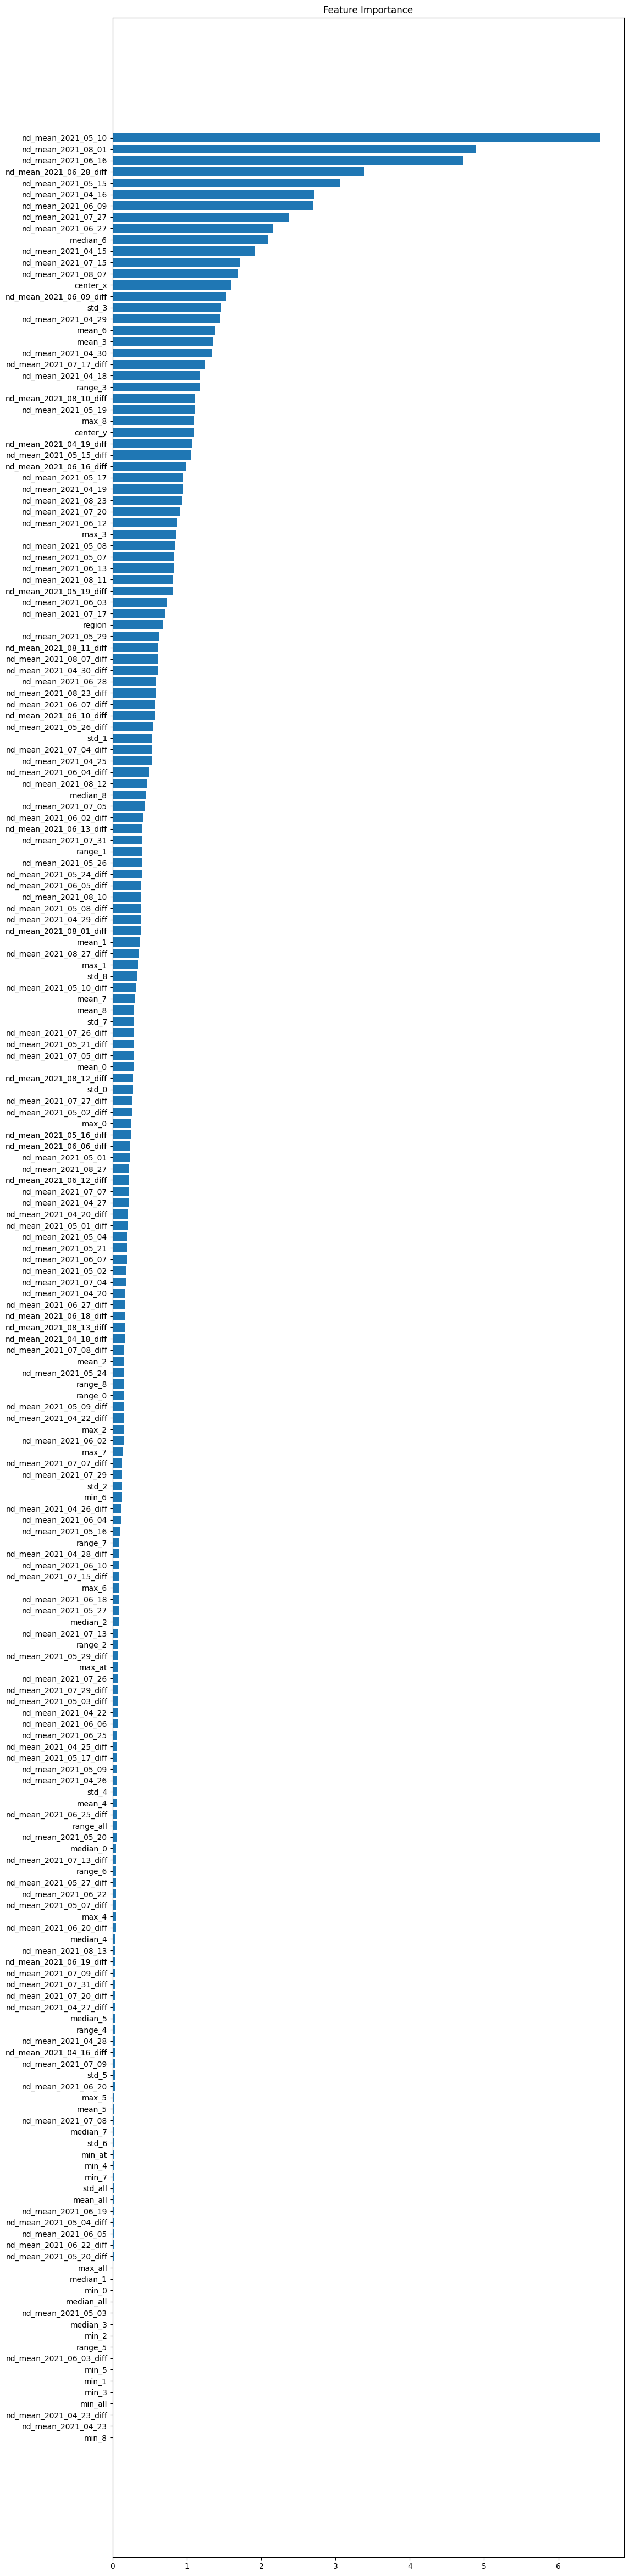

In [249]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 60))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [251]:
X_submission = test_df.drop(columns=drop_columns).rename(columns={c: c.replace('-', '_') for c in test_df.columns})

In [252]:
X_submission.head()

,nd_mean_2021_04_15,nd_mean_2021_04_16,nd_mean_2021_04_18,nd_mean_2021_04_19,nd_mean_2021_04_20,nd_mean_2021_04_22,nd_mean_2021_04_23,nd_mean_2021_04_25,nd_mean_2021_04_26,nd_mean_2021_04_27,...,nd_mean_2021_07_29_diff,nd_mean_2021_07_31_diff,nd_mean_2021_08_01_diff,nd_mean_2021_08_07_diff,nd_mean_2021_08_10_diff,nd_mean_2021_08_11_diff,nd_mean_2021_08_12_diff,nd_mean_2021_08_13_diff,nd_mean_2021_08_23_diff,nd_mean_2021_08_27_diff
id,,,,,,,,,,,,,,,,,,,,,
611,0.083038,0.196691,0.244827,0.000000,0.241219,0.259303,0.064947,0.066446,0.052522,0.153113,...,0.651112,-0.719171,0.593911,-0.593911,0.000000,0.192016,-0.027176,0.549453,-0.649263,0.019167
6417,0.122470,0.091192,0.241003,0.000000,0.181600,0.125823,0.108175,0.081871,0.000000,0.183747,...,-0.158874,0.012132,-0.329803,0.007428,-0.007428,0.106484,0.060995,-0.167479,0.000000,0.108945
3352,0.259347,0.000000,0.297489,0.033368,0.000000,0.285057,0.374026,0.000000,0.028275,0.261710,...,0.503355,-0.534127,0.549128,-0.549128,0.026141,0.443211,0.008030,-0.439543,-0.037838,0.158279
4224,0.166209,0.111243,0.000000,0.201012,0.083885,0.000000,0.015033,0.065305,0.000000,0.096765,...,0.028870,-0.167418,0.084049,-0.646207,0.658129,-0.079173,0.019615,-0.525296,0.423957,-0.295205
3102,0.010862,0.000000,0.067479,0.234954,0.000000,0.000000,0.000000,0.103583,0.305964,0.067257,...,-0.039066,0.134136,0.646169,-0.750080,0.016669,-0.046893,0.779191,-0.730568,0.602119,-0.529446


In [253]:
y_submission = model.predict(Pool(X_submission[selected['selected_features_names']]))

/home/eugen/PycharmProjects/inno-ndvi/venv/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [254]:
submission_df = test_df.copy()
submission_df["crop"] = y_submission
submission_df = submission_df[["crop"]]
submission_df.to_csv(DATA_DIR + "submission.csv")

0.9716570147316219


/home/eugen/PycharmProjects/inno-ndvi/venv/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


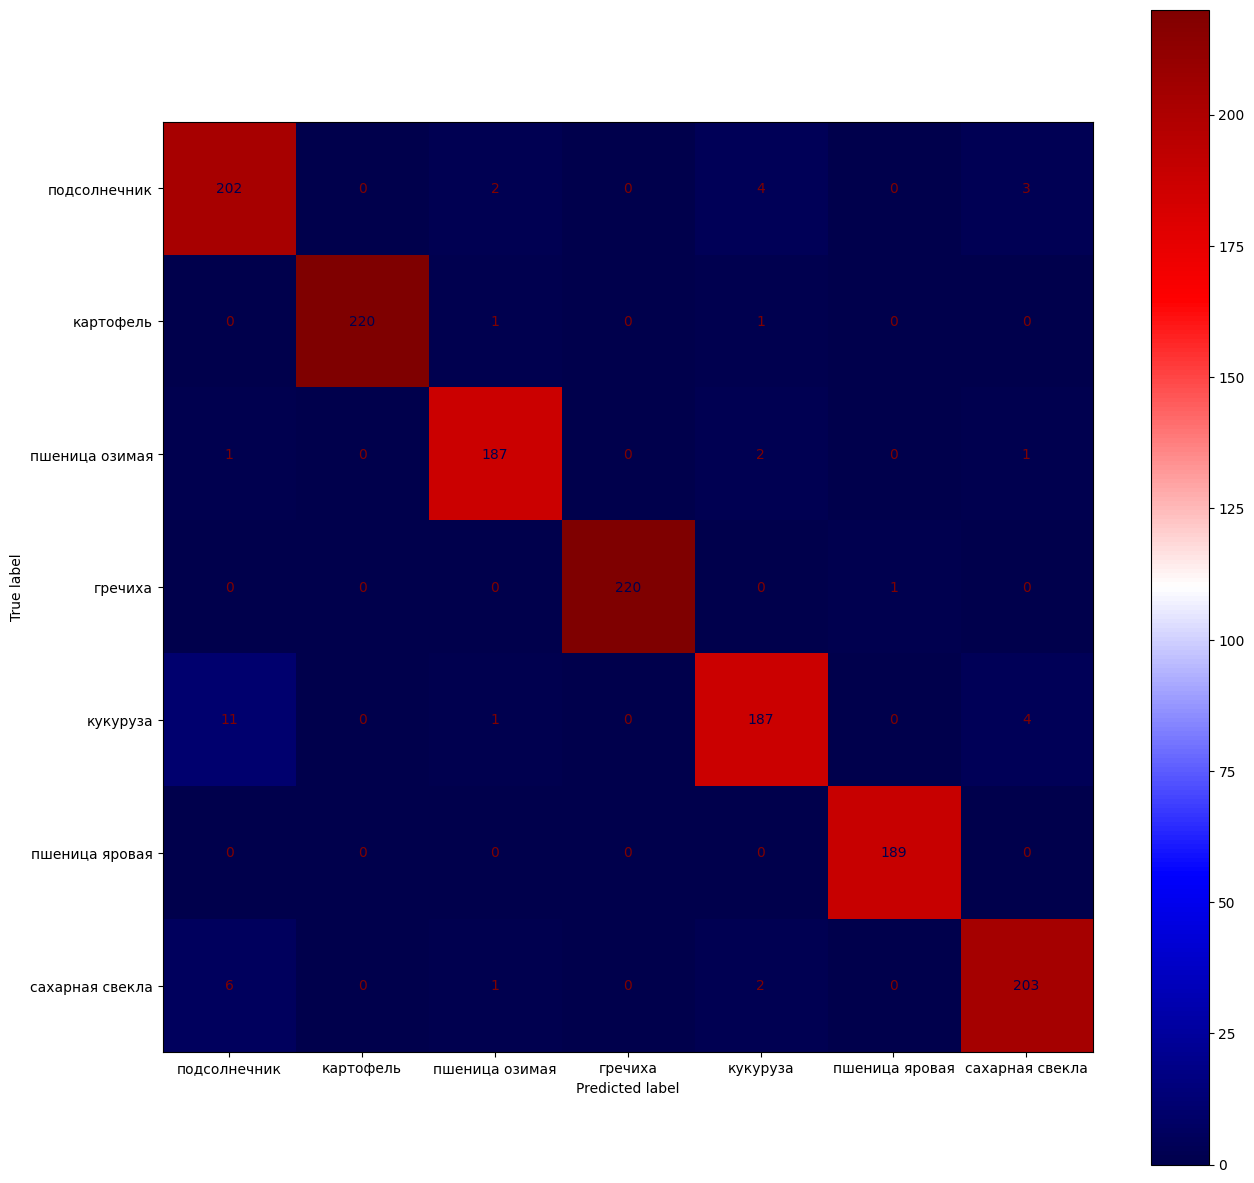

In [250]:
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

pred = model.predict(Pool(X_test))
print(recall_score(y_test, pred, average='macro'))

plt.rcParams['figure.figsize'] = (15, 15)

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm, display_labels=['подсолнечник', 'картофель', 'пшеница озимая', 'гречиха', 'кукуруза', 'пшеница яровая', 'сахарная свекла']).plot(cmap='seismic')